In [1]:
!nvidia-smi

Thu Sep 14 10:32:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8               7W /  80W |   6269MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
# re-size all the images to this 
IMAGE_SIZE = [224,224]
train_path = 'Datasets/train'
valid_path = 'Datasets/test'

In [6]:
vgg16 = VGG16(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

In [8]:
for layer in vgg16.layers:
    print(f"{layer.name} : {layer.trainable}")

input_1 : True
block1_conv1 : True
block1_conv2 : True
block1_pool : True
block2_conv1 : True
block2_conv2 : True
block2_pool : True
block3_conv1 : True
block3_conv2 : True
block3_conv3 : True
block3_pool : True
block4_conv1 : True
block4_conv2 : True
block4_conv3 : True
block4_pool : True
block5_conv1 : True
block5_conv2 : True
block5_conv3 : True
block5_pool : True


In [9]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [13]:
# useful for getting number of output classes
folders = glob('Datasets/train/*')

In [14]:
folders

['Datasets/train\\diseased cotton leaf',
 'Datasets/train\\diseased cotton plant',
 'Datasets/train\\fresh cotton leaf',
 'Datasets/train\\fresh cotton plant']

In [15]:
x = Flatten()(vgg16.output)

In [16]:
len(folders)

4

In [17]:
prediction = Dense(len(folders), activation='softmax')(x)

In [19]:
model = Model(inputs=vgg16.input, outputs=prediction)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [30]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [31]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [32]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [33]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 106 images belonging to 4 classes.


In [45]:
len(training_set), len(test_set)

(61, 4)

In [35]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


C:\Users\Dell\anaconda3\envs\GPUEnv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
61/61 [==============================] - 60s 973ms/step - loss: 0.7166 - accuracy: 0.7540 - val_loss: 0.2492 - val_accuracy: 0.9245
Epoch 2/20
61/61 [==============================] - 26s 424ms/step - loss: 0.2209 - accuracy: 0.9247 - val_loss: 0.2309 - val_accuracy: 0.9057
Epoch 3/20
61/61 [==============================] - 31s 515ms/step - loss: 0.1934 - accuracy: 0.9329 - val_loss: 0.2880 - val_accuracy: 0.8774
Epoch 4/20
61/61 [==============================] - 32s 526ms/step - loss: 0.1471 - accuracy: 0.9518 - val_loss: 0.1870 - val_accuracy: 0.9434
Epoch 5/20
61/61 [==============================] - 30s 493ms/step - loss: 0.1224 - accuracy: 0.9610 - val_loss: 0.1276 - val_accuracy: 0.9528
Epoch 6/20
61/61 [==============================] - 24s 400ms/step - loss: 0.0861 - accuracy: 0.9754 - val_loss: 0.1178 - val_accuracy: 0.9717
Epoch 7/20
61/61 [==============================] - 24s 391ms/step - loss: 0.0953 - accuracy: 0.9692 - val_loss: 0.1279 - val_accuracy: 0.9528

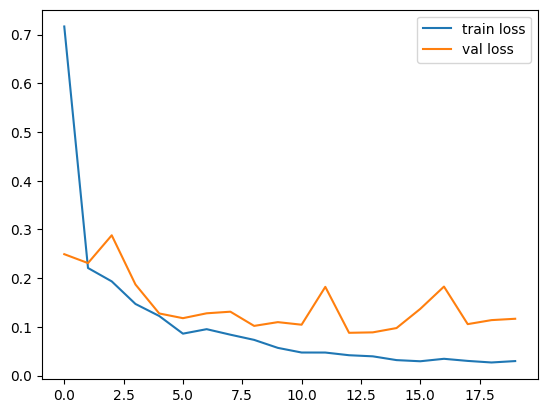

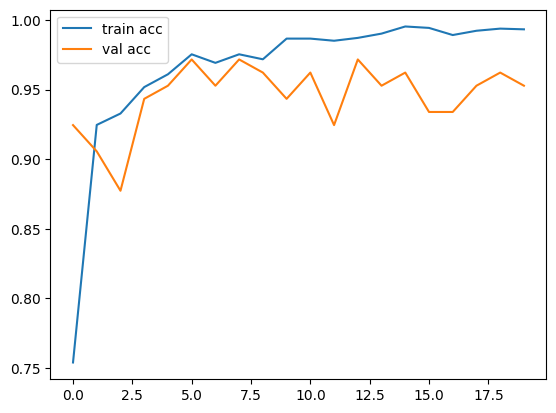

<Figure size 640x480 with 0 Axes>

In [36]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [37]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [38]:
y_pred = model.predict(test_set)

In [39]:
y_pred

array([[1.50841486e-04, 6.97350288e-06, 9.99840856e-01, 1.31801244e-06],
       [6.64935413e-08, 3.81163991e-04, 9.57332759e-06, 9.99609292e-01],
       [9.99999046e-01, 6.38475797e-07, 3.22760627e-07, 1.62222342e-08],
       [4.84336127e-09, 3.90936561e-10, 2.35666917e-07, 9.99999762e-01],
       [7.83373616e-06, 8.21669281e-01, 3.66337736e-05, 1.78286284e-01],
       [1.76617654e-08, 5.28877854e-06, 2.01626861e-07, 9.99994397e-01],
       [2.74081503e-06, 7.71609366e-01, 1.59229728e-06, 2.28386357e-01],
       [4.72104574e-07, 1.08934195e-09, 9.99999523e-01, 5.64543390e-09],
       [6.06246218e-08, 9.99957919e-01, 3.28308420e-06, 3.86192587e-05],
       [4.50245267e-07, 9.99565661e-01, 3.30789703e-07, 4.33569978e-04],
       [5.05095734e-08, 2.85237620e-04, 2.50699904e-05, 9.99689698e-01],
       [1.92462576e-05, 5.67504976e-08, 9.99978423e-01, 2.30982278e-06],
       [1.12635701e-06, 1.48711461e-08, 9.99998808e-01, 1.27514818e-10],
       [9.99990940e-01, 2.65542235e-06, 6.42516397e

In [40]:
y_pred = np.argmax(y_pred, axis=1)

In [41]:
y_pred

array([2, 3, 0, 3, 1, 3, 1, 2, 1, 1, 3, 2, 2, 0, 1, 2, 3, 1, 0, 1, 1, 0,
       2, 3, 1, 3, 1, 3, 2, 1, 1, 3, 0, 1, 3, 3, 1, 1, 2, 0, 2, 0, 1, 0,
       1, 1, 2, 2, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 0, 3,
       3, 1, 1, 0, 1, 1, 2, 1, 0, 3, 2, 1, 2, 1, 2, 2, 0, 0, 0, 3, 3, 3,
       0, 2, 3, 0, 2, 2, 1, 2, 1, 0, 0, 3, 0, 3, 2, 2, 2, 3], dtype=int64)